# Final Homework & In Class Assignment 
### This will be graded as a homework assignment, Due May 3, 2019 at 11:59pm

Over the next 4 lectures you will develop a machine learning algorithm to
classify Gray, White and CSF segmentatoin maps from t1 and t2 weighted images.

This assignment is an extension of the MIATT_INCLASS work that we have been performing over the past several lectures. Your challenge is to develop a medical imaging machine learning algorithm to segment brains into gray, white, and csf segmentations.  A segmentation image is one where values greater to 0.5 are considered to be part of the segmentation, and values less or equal to 0.5 are not part of the segmentation.

The files `HW8.ipynb` and `HW8functions.py` should be placed in your `inclass3-abpwrs/MIATT2019_ML` directory

## GRADING:

| Points  | Description           |
|---------|-----------------------|
| 60      | The documentation that describes why and what you are attempting to do |
| 15      | Employing reproducable science techniques |
| 10      | Quality of the segmentations on the hidden data sets |
| 15      | Quality of the analytics used to evaluate the intermediate results |
| | |
| 33 | Extra credit for the best solutions |
| 20 | Extra credit for the second best solutions |
| 10 | Extra credit for the third place best solutions |

There will be at least 3 extra credit prizes given to the best solutions.


## Data

A large data set has been organized in '/nfsscratch/opt/ece5490/data/MIATT_EYES' (This is too large to download)

Within this directory there are subjectories named with a 4 digit subject identifier, followed by a session directory indicating the when the scan was collected (always '_hcpy1' in this assignment).

| Image data paths for subject 0144 |
|------------------------------------|
|0144/0144_hcpy1/ACPCAlign/BCD_ACPC_Landmarks.fcsv|
|0144/0144_hcpy1/ACPCAlign/Cropped_BCD_ACPC_Aligned.nii.gz|
|0144/0144_hcpy1/ACCUMULATED_POSTERIORS/POSTERIOR_BACKGROUND_TOTAL.nii.gz|
|0144/0144_hcpy1/ACCUMULATED_POSTERIORS/POSTERIOR_CSF_TOTAL.nii.gz|
|0144/0144_hcpy1/ACCUMULATED_POSTERIORS/POSTERIOR_GLOBUS_TOTAL.nii.gz|
|0144/0144_hcpy1/ACCUMULATED_POSTERIORS/POSTERIOR_GM_TOTAL.nii.gz|
|0144/0144_hcpy1/ACCUMULATED_POSTERIORS/POSTERIOR_VB_TOTAL.nii.gz|
|0144/0144_hcpy1/ACCUMULATED_POSTERIORS/POSTERIOR_WM_TOTAL.nii.gz|
|0144/0144_hcpy1/TissueClassify/t1_average_BRAINSABC.nii.gz|
|0144/0144_hcpy1/TissueClassify/t2_average_BRAINSABC.nii.gz|


The data shall be partitioned into the following sets:

| Image Range   | Description     |
| ------------- | -------------   |
| 0001 - 0100   | Hidden Tests    (You won't have access to these until class on May 2nd, they will be used for grading)  |
| 0101 - 0200   | Test Data       (Used for testing your models before submission)|
| 0201 - 0300   | Validation Data (Used for validating your models during training)|
| 0301 - 0804   | Trainging Data  (Used for training your models) |



## My model does not fit inside of a git repo, run the command below to download it.

In [3]:
!curl http://user.engineering.uiowa.edu/~abpwrs/RF.pickle -o RF.pickle

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  534M  100  534M    0     0   112M      0  0:00:04  0:00:04 --:--:--  112M


## My Approach

I treated this as a classification problem and **NOT** a regression problem.



My first attempt was a fully convolutional neural network consisting of 5 convolutional layers. I set the padding to `same` so that the image size wouldn't decrease with each `Conv3D`. I also used `Dropout` in an attempt to avoid overfitting of my model. I initially thought this model performed okay, but when I attempted to replicate the inference phase, I ran into lots of issues of inconsistent classifications and model loading failures. This model is **NOT** used for the inference below. You are welcome to look at the [STRAIGHT_CONV.ipynb](./STRAIGHT_CONV.ipynb), but it is a mess of me debugging the reproducibility error... This attempt is included to record my work on this hw.



My second attempt was a pretty traditional feature engineering approach. I selected features (t1 pixel intensity, t1 neighborhood avg, edge image pixel intensity, edge image neighborhood avg). I then trained a random forest model on these engineered features. The code for this classifier training validation and saving can be found in [RF_voxelwise.ipynb](./RF_voxelwise.ipynb).

## Label Mask Generation

The label mask is a 3D image of the same size, spacing, direction, and origin as the origional images, but each pixel intensity represents a class of tissue.     
I arbitrarily chose the following scalars to represent each tissue class:
```text
background -> 0
gm -> 1
wm -> 2
csf -> 3                
```

I created a `get_label_mask` method for my `Subject` class, so that retrieving the label mask would feel natural and be very intuitive (the same as `get_t1_image`).       
Below is the method I used to generate a label mask from probability masks:   
```python
# generate a label mask of the image based on the probabilities 
    def get_label_mask(self):
        """
        OUTPUTS:
            label_mask where
                background -> 0
                gm -> 1
                wm -> 2
                csf -> 3

        Processing:
            - highest probability wins the voxel
            - background probability mask will be used to exclude extraneous labels
        """
        # if the label mask as been computed, don't recompute
        if self.label_mask:
            return self.label_mask

        # threshold of acceptable background probability
        bg_thresh = 0.0001  # less that 1/100 % probability of background

        # get numpy array versions of all probability masks as floating point
        def get_im_as_float_arr(im):
            return sitk.GetArrayFromImage(im).astype(np.float)
        
        gm = get_im_as_float_arr(self.get_gm_prob_mask())
        wm = get_im_as_float_arr(self.get_wm_prob_mask())
        csf = get_im_as_float_arr(self.get_csf_prob_mask())
        bg = get_im_as_float_arr(self.get_bg_prob_mask())

        # mask where grey matter has the highest probability
        gm_mask = sitk.GetImageFromArray((gm > 0.5) * 1)
        # gm has a label value of 1

        # mask where white matter has the highest probability
        wm_mask = sitk.GetImageFromArray((wm > 0.5) * 2)
        # wm has a label value of 2

        # mask where csf has the highest probability
        csf_mask = sitk.GetImageFromArray((csf > 0.5) * 3)
        # csf has a label value of 3

        # copy over information using t1 image
        t1_im = self.get_t1_image()
        gm_mask.CopyInformation(t1_im)
        wm_mask.CopyInformation(t1_im)
        csf_mask.CopyInformation(t1_im)

        # masks will not overlap because we created them based on the
        # highest probability values
        self.label_mask = sitk.Cast(gm_mask + wm_mask + csf_mask, sitk.sitkUInt8)
        return self.label_mask
```

# First Attempt --> CNN w/ keras (reproducability failure)

### The Model (purely convolutional network on the image level)
``` text
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv3d (Conv3D)              (None, 128, 128, 128, 32) 896       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 128, 128, 128, 32) 27680     
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 128, 32) 0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 128, 128, 128, 32) 27680     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 128, 32) 0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 128, 128, 128, 32) 27680     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 128, 128, 32) 0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 128, 128, 128, 1)  865       
=================================================================
Total params: 84,801
Trainable params: 84,801
Non-trainable params: 0
_________________________________________________________________
```

### Issues I Ran Into
* Memory Issues
    * Can only load a limited number of images into RAM, which would force me to use a method that loads and cleans images right before the image is fed into the network.
   
* Reproducable science issues
    * I noticed inconsistent segmentations for the same image across multiple runs
    * The model also failed to load depending on the run
    * The model also gave lots of `out of memory` errors when it was nowhere near it's RAM limits


Due to these issues, I only used 100 images as my training data and 10 images as validation. In addition, this model is not used for my final classifcation, a much more naive sklearn model is used.
    
### Performance
**THIS MODEL PERFORMED POORLY!!!!!**   
**AS THIS IS NOT REPRODUCIBLE ALL PERFORMANCE METRICS SHOULD BE TAKEN WITH A GRAIN OF SALT.**       
It "achieved" 87% validation accuracy during training without actually learning the segmentations.     
Around the $ {68}^{th} $ iteration the model training hit an error and I got unexpected behavior that plateaued the loss and accuracy at relatively bad values. This is likely due to a weight getting set to zero or some other fault in the network weights.

#### Loss (Mean Squared Error)
![](./imgs/e-loss-miatt-hw8.png)
![](./imgs/e-val-loss-miatt-hw8.png)

#### Accuracy
![](./imgs/e-acc-miatt-hw8.png)
![](./imgs/e-val-acc-miatt-hw8.png)

#### The Segmentation at Iteration 65 
![](./imgs/STRAIGHT_CONV_RESULT.png)

### Quantitative Analysis of CNN Segmentation
These metrics however come from the **attempt** at reproducing these result. The reproductions labeled the majority of pixels as background, and I would image that this is what could have caused the flatline that I saw in my loss function above.
     
$$
\begin{bmatrix}
label &       jaccard &          dice &  false\_negative &  false\_positive \\
bg &  0.634772 &  0.776588 &        0.360939 &        0.010464 \\
gm &  0.213391 &  0.351727 &        0.044455 &        0.784469 \\
wm &  0.000648 &  0.001295 &        0.999218 &        0.996244 \\
csf &  0.016420 &  0.032310 &        0.976966 &        0.945908 \\
\end{bmatrix}
$$



# Second Attempt --> sklearn RF classifier

## Feature Engineering
* single pixel t1 intensities
* single pixel edge image intensities
* scalar for the **average** of a radius 4 region of intensities
* scalar for the **average** of a radius 4 region of edge image intensities

NOTE: I wanted to do neighborhood extraction, but it wasn't going to work with my time management of other courses.


## Expected Shapes
#### x_train.shape = (n_samples, 4)
#### y_train.shape = (n_samples, 1) --> These are not one hot encoded

## Quantitative Analysis




#### Confusion Matrix (single image)
![](./imgs/rf_confusion_matrix.png)




#### Classification Report (single image)
![](./imgs/random_forest_clf_report.png)




#### Metrics on All TEST Data
$
\begin{bmatrix}
label & jaccard & dice & false\_negative & false\_positive\\
0 & 0.877616 & 0.934522 & 0.042732 & 0.086233 \\
1 & 0.437436 & 0.592840 & 0.436986 & 0.368031 \\
2 & 0.567557 & 0.694469 & 0.275988 & 0.295521 \\
3 & 0.162507 & 0.275819 & 0.808682 & 0.464798 \\ 
\end{bmatrix}
$



Plot of the above metrics: 

![](./imgs/all-test-data-metrics.png)

### Interpretation of Quantitative results
The CSF is commonly being confused for the background of the image. This could be improved by providing a neighborhood feature to give insight about csf location within the image. I could also do a binary classification on the background first and then do categorical classification on CSF, GM, WM.

## Qualitative Analysis

It's not bad. It isn't the quality of segmentation that I would want, but for just a random forest model on the voxel level it performs suprisingly well.   




![](./imgs/qualitative-analysis-rf.png)

# Future Considerations
If this problem were to be continued further I would do the following things:
* Histogram normalization across the entire dataset --> this would just be another preprocessing step
* Fix the Deep Learning model loading issue. --> this would open doors to more complex Deep Learning models
* Neighboorhood level feature extraction --> this would provide more spatial context to the traditional ML models
* Hierarchical learning --> this could help fix my CSF misclassification by first classifying the background, which has both high precision and recall and then moving on to the CSF as a secondary segmentation

In [12]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [11]:
import os
import itk
import glob
import sys

from itkwidgets import view
import numpy as np

from ipywidgets import interact, fixed
from ipywidgets import interactive
import ipywidgets as widgets
import SimpleITK as sitk
import pandas as pd
from matplotlib import pyplot as plt

# Place utility functions in the HW8functions.py file as you complete them
# you may want to put them inline the in the notebook for initial testing
# but only your HW8functions file will be used for final validation.
from HW8functions import Subject, GLB_DATA_DIR, estimate_gray_white_csf, HCPData, ModeKeys, Evaluator, OverlapMeasures

current_subject = Subject('0100')
t1_fn = current_subject.get_t1_filename()
t1_im = sitk.ReadImage(t1_fn, sitk.sitkFloat32)

t2_fn = current_subject.get_t2_filename() 
t2_im = sitk.ReadImage(t1_fn, sitk.sitkFloat32)

gray_matter_im, white_matter_im, csf_im = estimate_gray_white_csf(t1_im, t2_im)
# sitk.WriteImage(t1_im,"/tmp/t1.nii.gz")
# sitk.WriteImage(gray_matter_im,"/tmp/gm.seg.nii.gz")
# sitk.WriteImage(white_matter_im,"/tmp/wm.seg.nii.gz")
# sitk.WriteImage(csf_im,"/tmp/csf.seg.nii.gz")
# sitk.WriteImage(((csf_im*3)+(white_matter_im*2)+(gray_matter_im*1)), "/tmp/pred.seg.nii.gz")

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.9s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.1s finished


In [2]:
dataset = HCPData()
print("HCPData Overview:")
print("{0} total subjects".format(len(dataset.get_subjects())))
print("{0} hidden test subjects".format(len(dataset.get_subjects(ModeKeys.HIDDEN_TEST))))
print("{0} test subjects".format(len(dataset.get_subjects(ModeKeys.TEST))))
print("{0} validation subjects".format(len(dataset.get_subjects(ModeKeys.VAL))))
print("{0} training subjects".format(len(dataset.get_subjects(ModeKeys.TRAIN))))

HCPData Overview:
805 total subjects
100 hidden test subjects
100 test subjects
100 validation subjects
505 training subjects


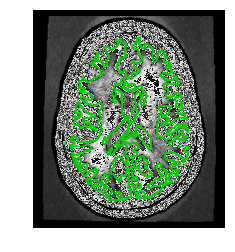

In [3]:
Evaluator.display_with_overlay(image=t1_im,segs=[gray_matter_im, white_matter_im, csf_im], slice_number=100, segmentation_number=1)

\begin{tabular}{lrrrr}
\toprule
{} &   jaccard &      dice &  false\_negative &  false\_positive \\
\midrule
0 &  0.905418 &  0.950362 &        0.030962 &        0.067609 \\
1 &  0.471393 &  0.640744 &        0.443716 &        0.244557 \\
2 &  0.597857 &  0.748323 &        0.113436 &        0.352622 \\
3 &  0.172547 &  0.294312 &        0.804466 &        0.405227 \\
\bottomrule
\end{tabular}



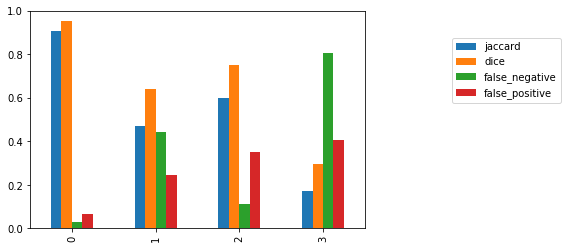

,jaccard,dice,false_negative,false_positive
0,0.905418,0.950362,0.030962,0.067609
1,0.471393,0.640744,0.443716,0.244557
2,0.597857,0.748323,0.113436,0.352622
3,0.172547,0.294312,0.804466,0.405227


In [4]:
lbl_mask = current_subject.get_label_mask()
background = ((gray_matter_im + white_matter_im + csf_im) < 1)
preds = [background, gray_matter_im, white_matter_im, csf_im]
ground_truth = [lbl_mask==0, lbl_mask==1,lbl_mask==2,lbl_mask==3]
Evaluator.get_segmentation_stats(ground_truth_segmentations=ground_truth, predicted_segmentations=preds, graph=True, latex=True)

## Compute Average of all metrics across all subjects

In [5]:
subs = dataset.get_subjects(ModeKeys.TEST)
l = len(subs)
avg_arr = np.zeros((4, 4))
for ind, sub in enumerate(subs):
    print("{0}%".format((ind/l)*100))
    lbl_mask = sub.get_label_mask()
    gray_matter_im, white_matter_im, csf_im = estimate_gray_white_csf(sub.get_t1_image(), sub.get_t2_image())
    background = ((gray_matter_im + white_matter_im + csf_im) < 1)
    preds = [background, gray_matter_im, white_matter_im, csf_im]
    ground_truth = [lbl_mask==0, lbl_mask==1,lbl_mask==2,lbl_mask==3]
    avg_arr += Evaluator.get_segmentation_stats(ground_truth_segmentations=ground_truth, predicted_segmentations=preds, graph=False, latex=False).values

0.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.9s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.6s finished


1.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   16.1s finished


2.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.6s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   17.0s finished


3.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   15.6s finished


4.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    4.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   19.1s finished


5.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   15.9s finished


6.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.6s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   17.2s finished


7.000000000000001%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    4.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.8s finished


8.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    4.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   19.1s finished


9.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.6s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   16.8s finished


10.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    4.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.2s finished


11.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.8s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   17.8s finished


12.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    4.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.8s finished


13.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.7s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   17.5s finished


14.000000000000002%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   15.8s finished


15.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.8s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.1s finished


16.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.9s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   17.6s finished


17.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.5s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   16.6s finished


18.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.6s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   17.5s finished


19.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.8s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   17.9s finished


20.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.9s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.4s finished


21.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.8s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   17.7s finished


22.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   15.9s finished


23.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.7s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   17.8s finished


24.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   16.5s finished


25.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.7s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   17.4s finished


26.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.9s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.6s finished


27.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.5s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   16.5s finished


28.000000000000004%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.6s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   17.4s finished


28.999999999999996%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.8s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.3s finished


30.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    4.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.9s finished


31.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.9s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.2s finished


32.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.8s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.0s finished


33.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.9s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.1s finished


34.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.9s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.5s finished


35.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   16.7s finished


36.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.8s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   17.9s finished


37.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.7s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.2s finished


38.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    4.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.9s finished


39.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.8s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.4s finished


40.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    4.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   19.2s finished


41.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.5s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   16.6s finished


42.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.6s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   17.4s finished


43.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   16.4s finished


44.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    4.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   19.2s finished


45.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.8s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   17.7s finished


46.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.8s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.4s finished


47.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.7s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   17.2s finished


48.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    4.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.7s finished


49.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   16.3s finished


50.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    4.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.7s finished


51.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.8s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   17.8s finished


52.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    4.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.6s finished


53.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.9s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.3s finished


54.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.7s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.0s finished


55.00000000000001%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.8s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.1s finished


56.00000000000001%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.9s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.4s finished


56.99999999999999%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.5s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   16.7s finished


57.99999999999999%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   16.2s finished


59.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    4.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.8s finished


60.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.8s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   17.9s finished


61.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.6s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   17.1s finished


62.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.8s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   17.6s finished


63.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.8s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   17.8s finished


64.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    4.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   19.0s finished


65.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.6s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   16.9s finished


66.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.7s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   17.6s finished


67.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    4.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   19.8s finished


68.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    4.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.9s finished


69.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.5s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   16.6s finished


70.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    4.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   19.1s finished


71.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   16.6s finished


72.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.6s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   17.1s finished


73.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.7s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   17.3s finished


74.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    4.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   19.1s finished


75.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    4.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.9s finished


76.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.6s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   17.5s finished


77.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   15.6s finished


78.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.5s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   16.8s finished


79.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   16.3s finished


80.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.6s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   17.3s finished


81.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.9s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.1s finished


82.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.9s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.4s finished


83.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.7s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   17.6s finished


84.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   15.9s finished


85.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.9s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.4s finished


86.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.9s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.3s finished


87.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    4.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.8s finished


88.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.6s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   16.8s finished


89.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.5s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   16.3s finished


90.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.6s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   17.1s finished


91.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.9s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.3s finished


92.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.9s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   17.9s finished


93.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.5s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   16.8s finished


94.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.6s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   17.0s finished


95.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   16.0s finished


96.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.8s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   17.6s finished


97.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    4.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   19.2s finished


98.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.5s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   16.7s finished


99.0%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    3.6s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   16.8s finished


In [6]:
avg_arr = avg_arr / len(subs)

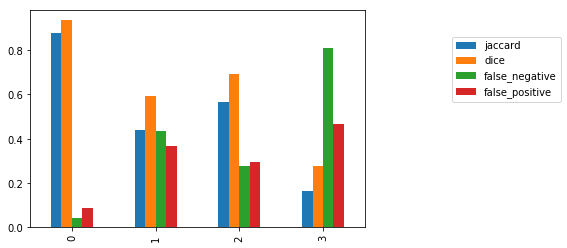

In [7]:
overlap_results_df = pd.DataFrame(data=avg_arr, index=list(range(4)), columns=[name for name, _ in OverlapMeasures.__members__.items()])
overlap_results_df.plot(kind='bar').legend(bbox_to_anchor=(1.6, 0.9))
plt.show()

In [8]:
overlap_results_df

,jaccard,dice,false_negative,false_positive
0,0.877616,0.934522,0.042732,0.086233
1,0.437436,0.592840,0.436986,0.368031
2,0.567557,0.694469,0.275988,0.295521
3,0.162507,0.275819,0.808682,0.464798
